# DVSA Data Engineering

<br>

### Imports

In [1]:
# Data wrangling
import pandas as pd
import numpy as np
import json

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import os
import copy
import requests
from warnings import warn

# Project specific
import helpers as hlp
import DVSA
import DVLA

# Display
from ipypb import track
from IPython.display import JSON, IFrame

# Loading environment variables 
from dotenv import load_dotenv
load_dotenv('../dependencies/.env');

<br>

### Helper Functions

In [2]:
hide_ax_spines = lambda ax, sides=['top', 'right']: [ax.spines[side].set_visible(False) for side in sides]
view_dict_head = lambda d, n=5: JSON(pd.Series(d).head(n).to_dict())

<br>

### API Documentation

In [3]:
IFrame('https://dvsa.github.io/mot-history-api-documentation/', width=850, height=500)

<br>

### User Input

Here we'll define all directories and other variables that require manual specification by the user

In [4]:
# API keys
VES_API_KEY = os.getenv('VES_API_KEY')
DVSA_API_KEY = os.getenv('DVSA_API_KEY')

# Directories
raw_data_dir = '../data/DVSA/raw'

# GCP Credentials
GCP_credentials_fp = '../dependencies/NAM-index-credentials.json'

<br>

### Using the Custom DVSA Client Library

The main end-point for the DVSA API contain pages of MOT test data, with each page holding roughly 490 tests

In [5]:
DVSA_wrapper = DVSA.Wrapper(DVSA_API_KEY)

r_json = DVSA_wrapper.query_API(page=50000)

hlp.view_dict_head(r_json)

<IPython.core.display.JSON object>

In [8]:
registration = 'A310RBM'

r_json = DVSA_wrapper.query_API(registration=registration)

hlp.view_dict_head(r_json)

<IPython.core.display.JSON object>

<br>

We can also query data for MOT tests on a specific date, where each page represents a minute (maximum 1440), in this example we'll query MOT tests between 10-11 AM on the 1st August 2020

In [ ]:
r_json = []

for page in track(range(600, 700+1)):
    r_json_page = DVSA_wrapper.query_API(date=20200801, page=page)
    r_json += [r_json_page]

hlp.view_dict_head(r_json)

<br>

We can also query the API for specific vehicle registration numbers

N.b. this query won't work unless a real vrn is used, for data protection reasons we cannot store a real vrn in the notebook

In [7]:
DVSA_wrapper = DVSA.Wrapper(DVSA_API_KEY)

r_json = DVSA_wrapper.query_API(registration='ZZ99ABC')

hlp.view_dict_head(r_json)

<IPython.core.display.JSON object>

<br>

As well as the main DVSA wrapper we also have a download manager that handles batch requests via the wrapper, as well as the subsequent transfer of the response data to a google cloud bucket.

Here we'll download a single page and save it to the bucket

In [8]:
start_page = 40000
end_page = 40001

download_manager = DVSA.DownloadManager(GCP_credentials_fp=GCP_credentials_fp)
download_manager.download_pages(start_page, end_page, raw_data_dir)

 [████████████████████████████████████████████████████████████] 1/1 [00:28<00:28, 27.67s/it]

<br>

We can check to see the coverage of MOT test data in the google bucket as well

49.33% of the pages have been downloaded


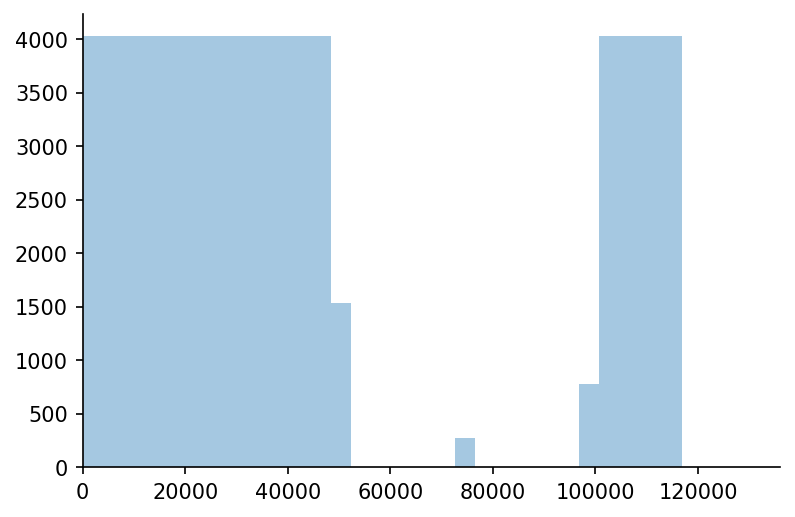

In [17]:
total_to_download = 136000
downloaded_files = download_manager.get_downloaded_pages()

fig, ax = plt.subplots(dpi=150)
sns.distplot(downloaded_files, kde=False, ax=ax)
hlp.hide_ax_spines(ax)
ax.set_xlim(0, total_to_download)

print(f'{round(100*len(downloaded_files)/total_to_download, 2)}% of the pages have been downloaded')

<br>

### Processing DVSA Data

Now that we have raw JSONs for each page of MOT data we need to process them.

First we'll extract vehicle metadata

In [10]:
r_json = DVSA_wrapper.query_API(page=50000)
df_vehicle_metadata = DVSA.extract_vehicle_metadata(r_json)

df_vehicle_metadata.head()

,make,model,firstUsedDate,registrationDate,manufactureDate,engineSize,fuelType,primaryColour,vehicleId
registration,,,,,,,,,
N547WHN,FORD,TRANSIT,1995.09.25,1995.09.25,1995.12.31,2496,Diesel,White,l508_CpCqVERGK3PpR9Amg==
N547WJA,VAUXHALL,ASTRA,1995.09.30,1995.09.30,1995.12.31,1389,Petrol,Gold,QYzSmgYhxIRRKAqoTS4Isg==
N547WJB,VAUXHALL,BRAVA 2.5D 4X2,1995.12.05,1995.12.05,1995.12.31,2499,Diesel,Red,grTmaYvFkRQ6yaU7KkeD0w==
N547WJL,PEUGEOT,306,1996.02.09,1996.02.09,1996.12.30,1905,Diesel,Red,vzybGFdxaXd9hI4J0bPRmw==
N547WJM,KAWASAKI,ZX-9R,1995.10.30,1995.10.30,1995.12.31,899,Petrol,Black,xMYeu1X6zZXXpo6LoRkKpQ==


<br>

Next we'll extract the MOT tests

In [11]:
df_vehicles_tests = DVSA.extract_vehicle_MOTs(r_json)

df_vehicles_tests.head()

 [████████████████████████████████████████████████████████████] 494/494 [00:01<00:00, 0.00s/it]

,completedDate,testResult,expiryDate,odometerValue,odometerUnit,odometerResultType,registration
motTestNumber,,,,,,,
180858707297,2007-07-27,PASSED,2008.07.26,161538,mi,READ,N547WHN
532740907272,2007-07-19,FAILED,NaN,161538,mi,READ,N547WHN
470093196180,2006-07-12,PASSED,2007.07.11,153073,mi,READ,N547WHN
231168686423,2006-07-07,FAILED,NaN,153073,mi,READ,N547WHN
235146442306,2012-12-11,PASSED,2013.12.26,102156,mi,READ,N547WJA


<br>

We'll also createa a wide dataframe for the odometer readings taken for each MOT

In [12]:
df_vehicle_mileage = DVSA.extract_mileage_from_tests(df_vehicles_tests)

df_vehicle_mileage.head()

registration,856GTD,N547WHN,N547WJA,N547WJB,N547WJL,N547WJM,N547WKK,N547WKM,N547WKN,N547WKO,...,N548CWK,N548CWL,N548CWM,N548CWP,N548CWR,N548CWT,N548CWU,N548CWY,N816TDW,N962PFB
completedDate,,,,,,,,,,,,,,,,,,,,,
2005-02-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-03-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-05-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<br>

Whilst it appears as though all the data is NaN it is actually just sparsely populated to ensure that the temporal resolution of the odometer readings is daily, we can see it more easily when viewed as a heatmap

<AxesSubplot:xlabel='registration', ylabel='completedDate'>

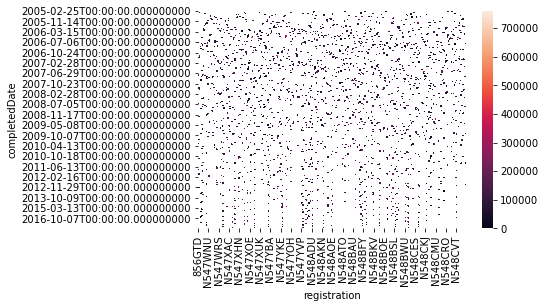

In [13]:
sns.heatmap(df_vehicle_mileage)

<br>

Whilst we can determine the test ids for specific vrns from the df_vehicles_tests dataframe when we start working with larger datasets this will take a long time, to help with filtering we can create a running database mapping from vrns to MOT test ids

In [14]:
reg_to_MOT_ids = DVSA.create_reg_to_MOT_ids_map(df_vehicles_tests)
    
hlp.view_dict_head(reg_to_MOT_ids) 

<IPython.core.display.JSON object>

<br>

We can wrap these 4 processing steps together through a single function, then quickly check that the outputs match what we expect

In [15]:
parsed_datasets = DVSA.parse_response(r_json)

assert df_vehicle_metadata.equals(parsed_datasets['metadata'])
assert df_vehicles_tests.equals(parsed_datasets['MOTs'])
assert df_vehicle_mileage.equals(parsed_datasets['mileage'])
assert reg_to_MOT_ids == parsed_datasets['reg_to_MOT_ids']

 [████████████████████████████████████████████████████████████] 494/494 [00:01<00:00, 0.00s/it]

<br>

Finally lets do a plot of some mileage data from the vehicles with the most MOT data-points

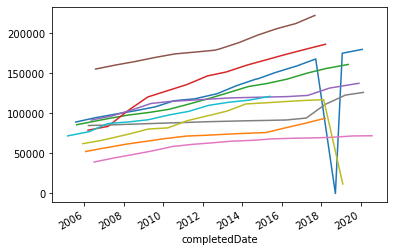

In [16]:
ten_vehicles_most_tests = (pd
                           .Series({
                               k:len(v) 
                               for k, v 
                               in reg_to_MOT_ids.items()
                           })
                           .sort_values(ascending=False)
                           [:10]
                           .index
                           .to_list()
                          )

for reg in ten_vehicles_most_tests:
    df_vehicle_mileage[reg].dropna().plot(legend=False)

<br>

### VES Data Retrieval

Whilst we can retrieve MOT data from the DVSA API we need to get additional vehicle metadata from an external source, in this case the DVLA VES API

N.b. co2Emissions appears to be in g/km based on similar values with units available through the DVLA website

In [8]:
vrn = 'DF66KDU'
API_key = 'nkZ2TmFCs76RVAlCm4ZUC32fE0uIgvcSeYRhJof2'
    
DVLA_wrapper = DVLA.Wrapper(API_key)
r_json = DVLA_wrapper.query_API(vrn)

JSON(r_json)

<IPython.core.display.JSON object>

In [ ]:
DVH909L, Q483XAF, EG02JUJ, DVW216G, DVJ220L, DVO237J, EG02KVV, EG02KLC, FHJ451D, BF5379

<br>

We can query VES data for a range of vrns that are returned from a page on the DVSA API, in doing so we can clearly see that the bottleneck is with the VES data which takes ~100x as long to retrieve and process

In [50]:
# Requesting DVSA MOT tests
r_json = DVSA_wrapper.query_API(page=1)

# Parsing MOT test data
parsed_datasets = DVSA.parse_response(r_json)
vrns = list(parsed_datasets['reg_to_MOT_ids'].keys())

# Requesting DVLA VES data
vehicle_VES_data = DVLA_wrapper.bulk_query(vrns)
        
# Parsing VES data
df_vehicle_VES = pd.DataFrame(vehicle_VES_data).T
df_vehicle_VES.index.name = 'vrn'

df_vehicle_VES.head()

 [████████████████████████████████████████████████████████████] 413/413 [00:02<00:00, 0.00s/it]

 [████████████████████████████████████████████████████████████] 409/409 [01:33<00:00, 0.23s/it]

34.72% of the vehicles could not be retrieved


,registrationNumber,co2Emissions,engineCapacity,markedForExport,fuelType,motStatus,colour,make,typeApproval,yearOfManufacture,...,taxStatus,dateOfLastV5CIssued,motExpiryDate,wheelplan,monthOfFirstRegistration,monthOfFirstDvlaRegistration,revenueWeight,artEndDate,euroStatus,realDrivingEmissions
vrn,,,,,,,,,,,,,,,,,,,,,
V590SVY,V590SVY,0,1349,False,PETROL,Not valid,SILVER,DAEWOO,M1,2000,...,Untaxed,2010-03-19,2012-08-13,2 AXLE RIGID BODY,2000-02,2006-09,NaN,NaN,NaN,NaN
V275DJU,V275DJU,NaN,1896,True,DIESEL,Not valid,RED,SKODA,NaN,2000,...,Untaxed,2012-03-16,2013-05-06,2 AXLE RIGID BODY,2000-02,2010-06,NaN,NaN,NaN,NaN
W656OSS,W656OSS,NaN,2459,False,DIESEL,Valid,RED,VOLKSWAGEN,NaN,2000,...,Taxed,2017-05-17,2021-04-14,2 AXLE RIGID BODY,2000-03,2014-04,NaN,NaN,NaN,NaN
W278UBC,W278UBC,0,1896,True,DIESEL,Not valid,BLUE,SKODA,NaN,2000,...,Untaxed,2015-08-04,2016-07-23,2 AXLE RIGID BODY,2000-03,2012-04,NaN,NaN,NaN,NaN
W58RAO,W58RAO,NaN,2370,False,DIESEL,Valid,BLUE,VOLKSWAGEN,NaN,2000,...,Taxed,2019-08-13,2021-07-10,2 AXLE RIGID BODY,2000-06,2014-07,NaN,NaN,NaN,NaN


<br>

### Generating Clean Mileage Dataset

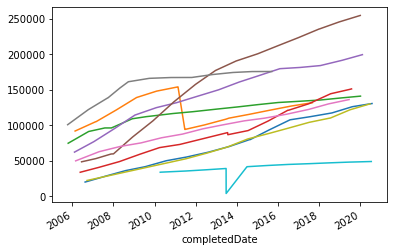

In [107]:
df_vehicle_mileage = parsed_datasets['mileage']
reg_to_MOT_ids = parsed_datasets['reg_to_MOT_ids']

ten_vehicles_most_tests = (pd
                           .Series({
                               k:len(v) 
                               for k, v 
                               in reg_to_MOT_ids.items()
                           })
                           .sort_values(ascending=False)
                           [:10]
                           .index
                           .to_list()
                          )

for reg in ten_vehicles_most_tests:
    df_vehicle_mileage[reg].dropna().plot(legend=False)

[None, None, None]

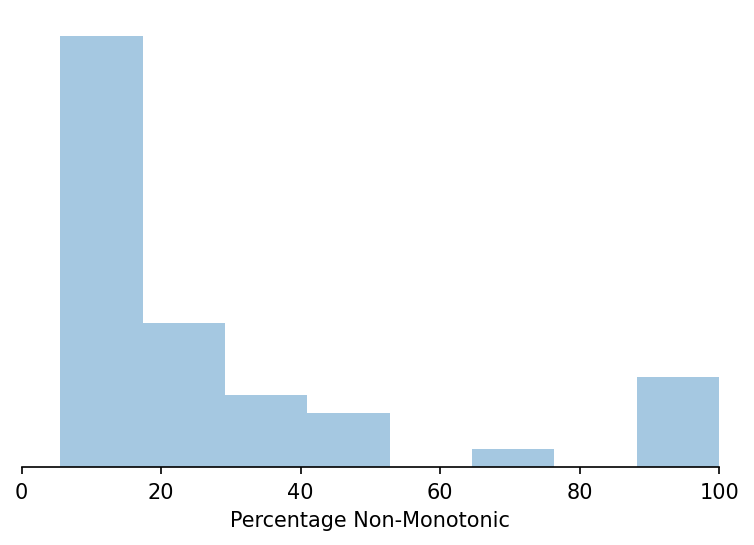

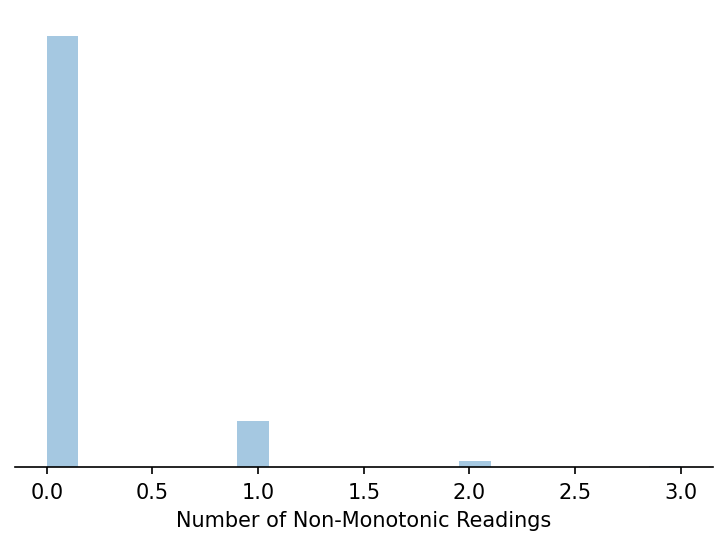

In [127]:
s_pct_monotonicity = pd.Series(index=df_vehicle_mileage.columns, dtype=float)
s_num_non_monotonic = pd.Series(index=df_vehicle_mileage.columns, dtype=int)

for vrn in df_vehicle_mileage.columns:
    s_vrn = df_vehicle_mileage.loc[:, vrn].dropna()
    num_non_monotonic = ((s_vrn - s_vrn.shift(-1)).dropna() > 0).sum()
    
    if s_vrn.shape[0] == 1:
        pct_non_monotonic = np.nan
    else:
        pct_non_monotonic = num_non_monotonic / (s_vrn.shape[0] - 1)

    s_num_non_monotonic.loc[vrn] = num_non_monotonic
    s_pct_monotonicity.loc[vrn] = pct_non_monotonic
        
# Plotting
fig, ax = plt.subplots(dpi=150)

sns.distplot(100*s_pct_monotonicity[s_pct_monotonicity>0], kde=False, ax=ax)

ax.set_xlabel('Percentage Non-Monotonic')
ax.set_xlim(0, 100)
ax.set_yticks([])
hlp.hide_ax_spines(ax, sides=['top', 'left', 'right'])

# Plotting
fig, ax = plt.subplots(dpi=150)

sns.distplot(s_num_non_monotonic, kde=False, ax=ax)

ax.set_xlabel('Number of Non-Monotonic Readings')
#ax.set_xlim(0, 100)
ax.set_yticks([])
hlp.hide_ax_spines(ax, sides=['top', 'left', 'right'])

<AxesSubplot:xlabel='registration', ylabel='completedDate'>

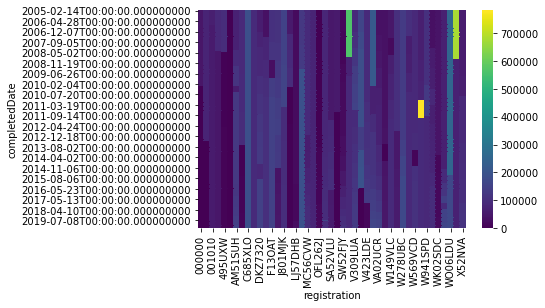

In [108]:
s_vrn_monotonicity = df_vehicle_mileage.apply(lambda s: s.dropna().is_monotonic)
non_monotonic_vrns = s_vrn_monotonicity[~s_vrn_monotonicity].index.to_list()

df_non_monotonic_vrns = df_vehicle_mileage[non_monotonic_vrns]

sns.heatmap(df_non_monotonic_vrns.ffill().bfill(), cmap='viridis')